In [1]:
import torch
import numpy as np 
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import pandas as pd

from kan import create_dataset, KAN, KANLayer
from kan.MLP import MLP

from sklearn.metrics import root_mean_squared_error, mean_absolute_error, r2_score
import shap


from source import plot_f_2d, plot_f_3d, scatter_prediction_kan, kan_summary_after_fit
from source import lmdKANLayer, lmdKAN, importance_analyse_lmdKAN


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

c:\Users\Gavriil\VS_projects\lambda_KAN\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu


-----
-----
## $f_1(x_1, x_2, x_3, x_4)$

## $x_3, x_4$ - normal random

##### $f_1(x_1, x_2, x_3, x_4) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$

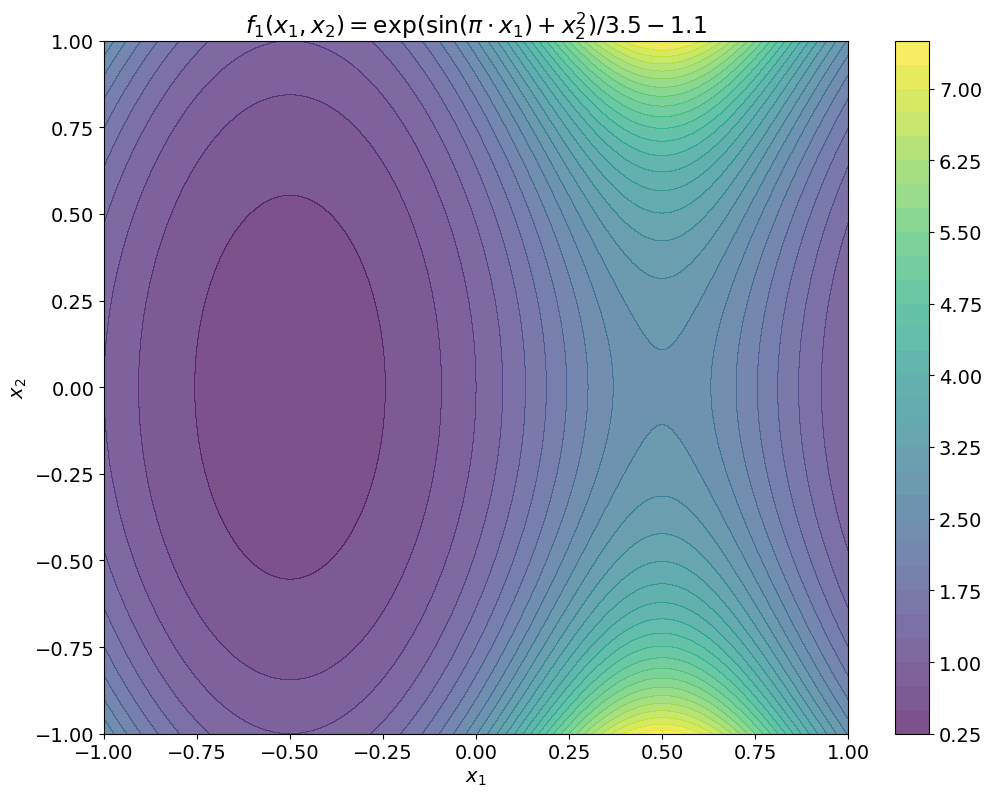

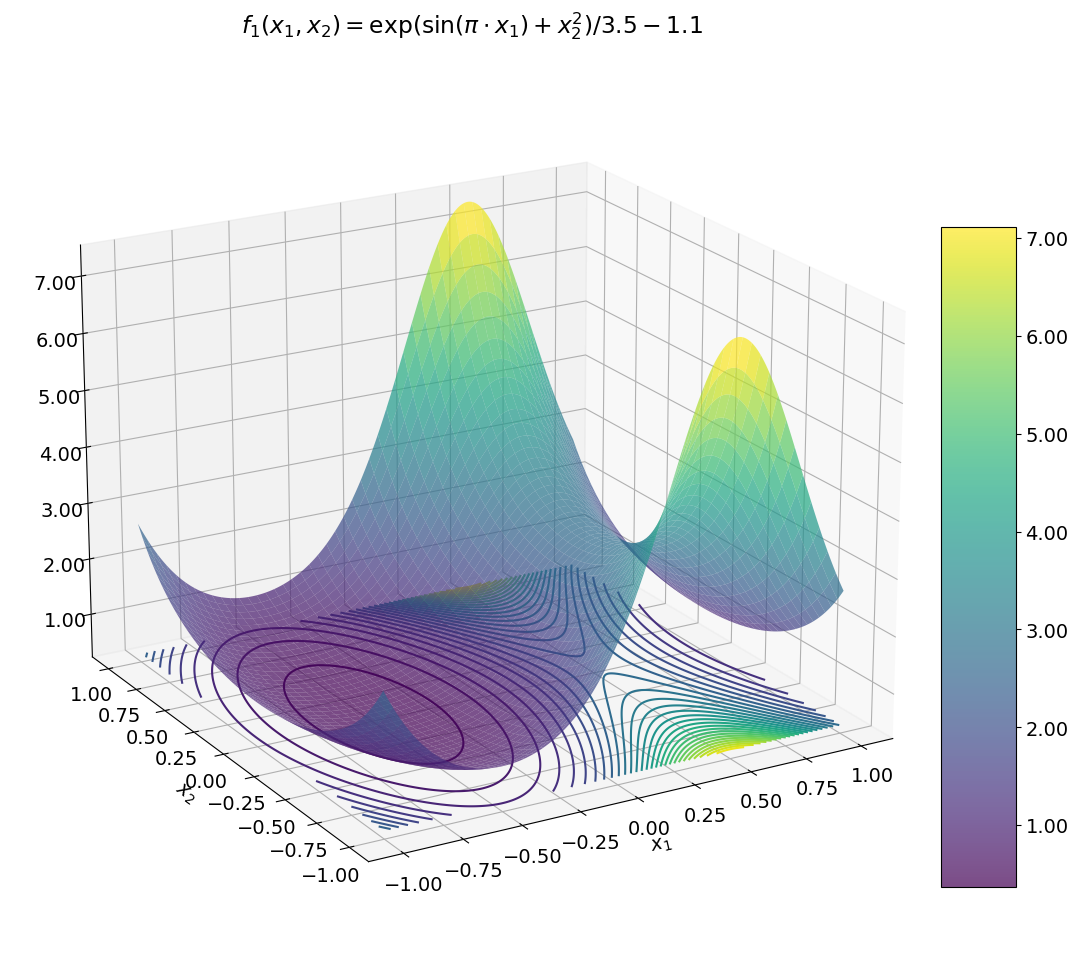

In [45]:
# create dataset
f1 = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset1 = create_dataset(f1, n_var=4, device=device)

f = f1
dataset = dataset1

plot_f_2d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_1$

№ model trainable params: 246


| train_loss: 3.60e-02 | test_loss: 4.73e-02 | reg: 1.12e+02 | : 100%|█| 100/100 [00:03<00:00, 26.48


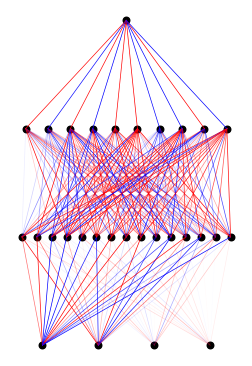

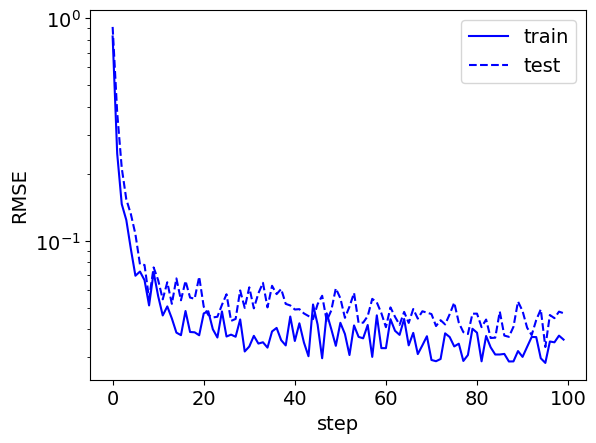

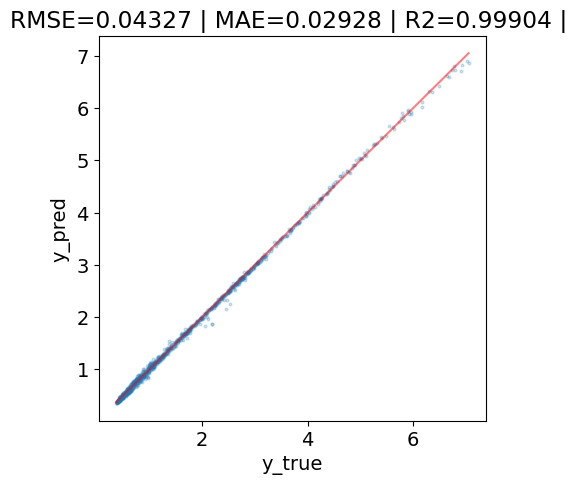

In [21]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 6.89e-03 | test_loss: 7.04e-03 | reg: 9.34e+00 | : 100%|█| 100/100 [00:25<00:00,  3.98


saving model version 0.1


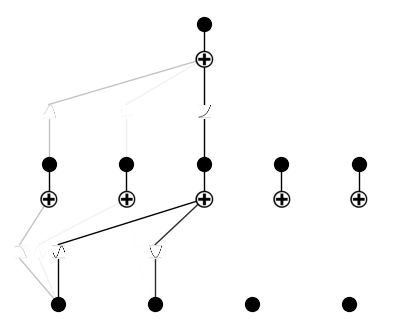

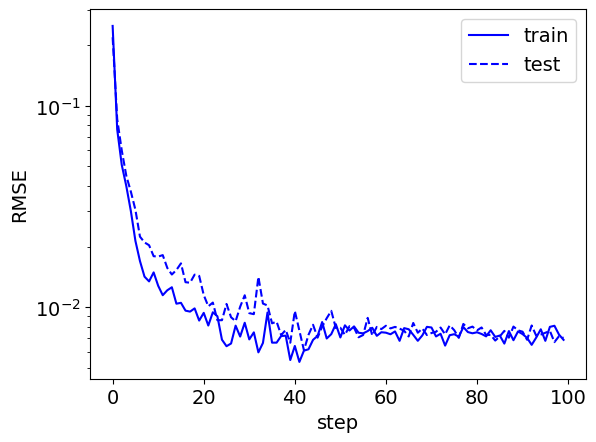

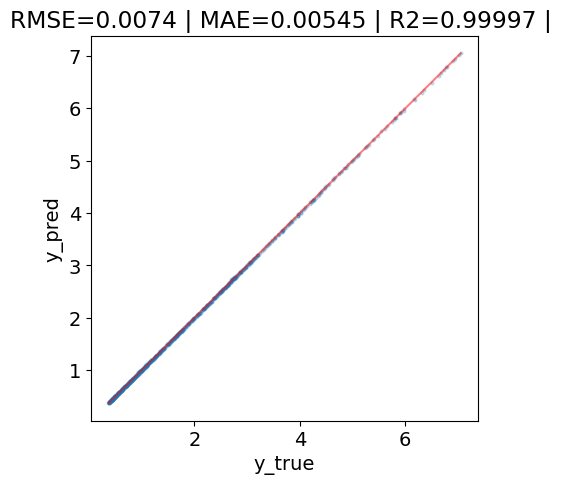

In [46]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### $\lambda$-KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 2.34e-01 | test_loss: 2.78e-01 | reg: 2.45e+01 | : 100%|█| 150/150 [00:49<00:00,  3.03


saving model version 0.1


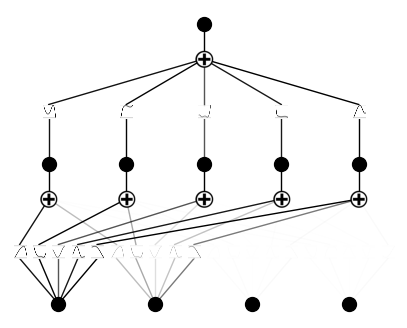

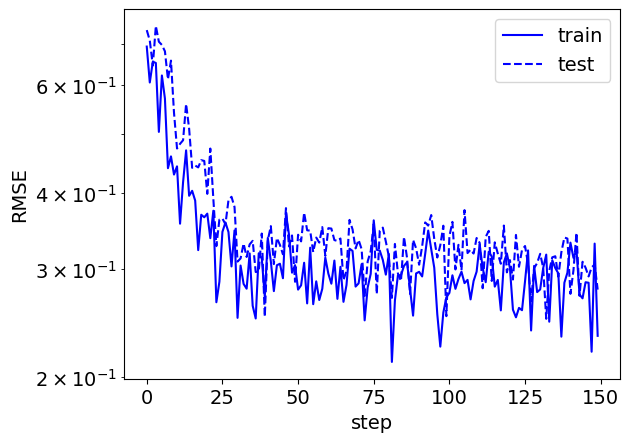

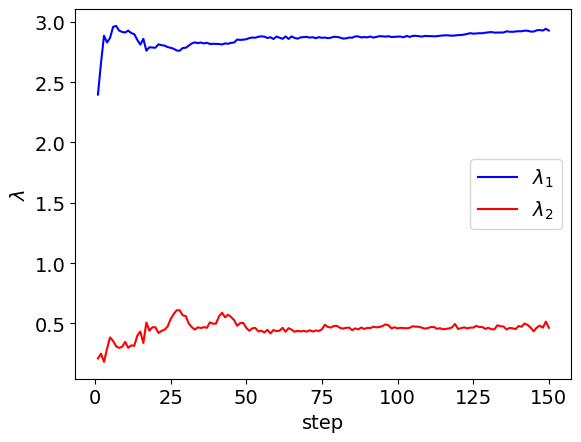

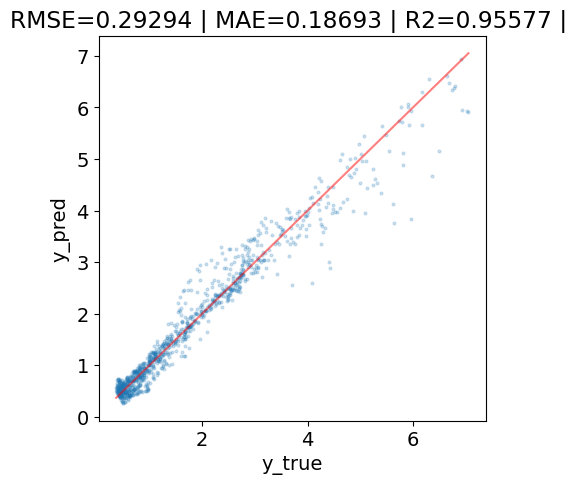

model.act_fun[0].lmd=Parameter containing:
tensor([ 2.9274,  0.4643,  0.0178, -0.0151], requires_grad=True)


In [4]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=1, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:30, 22.16it/s]                         


module of Input importance:


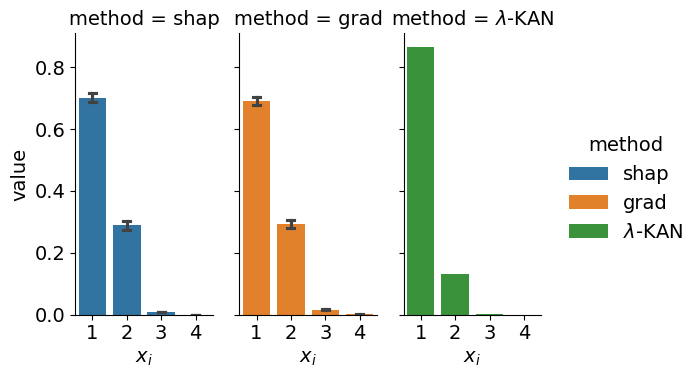

Input importance:


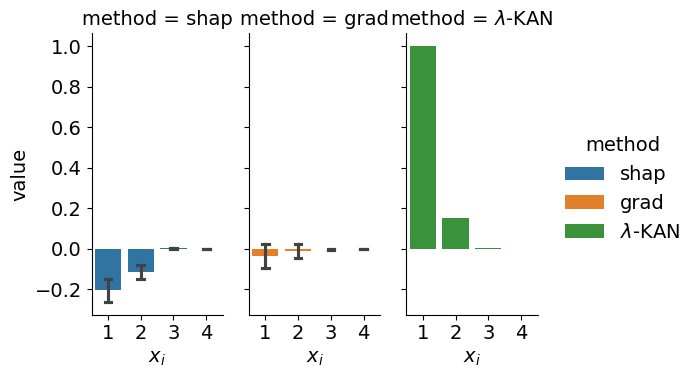

In [25]:
importance_analyse_lmdKAN(model, dataset)

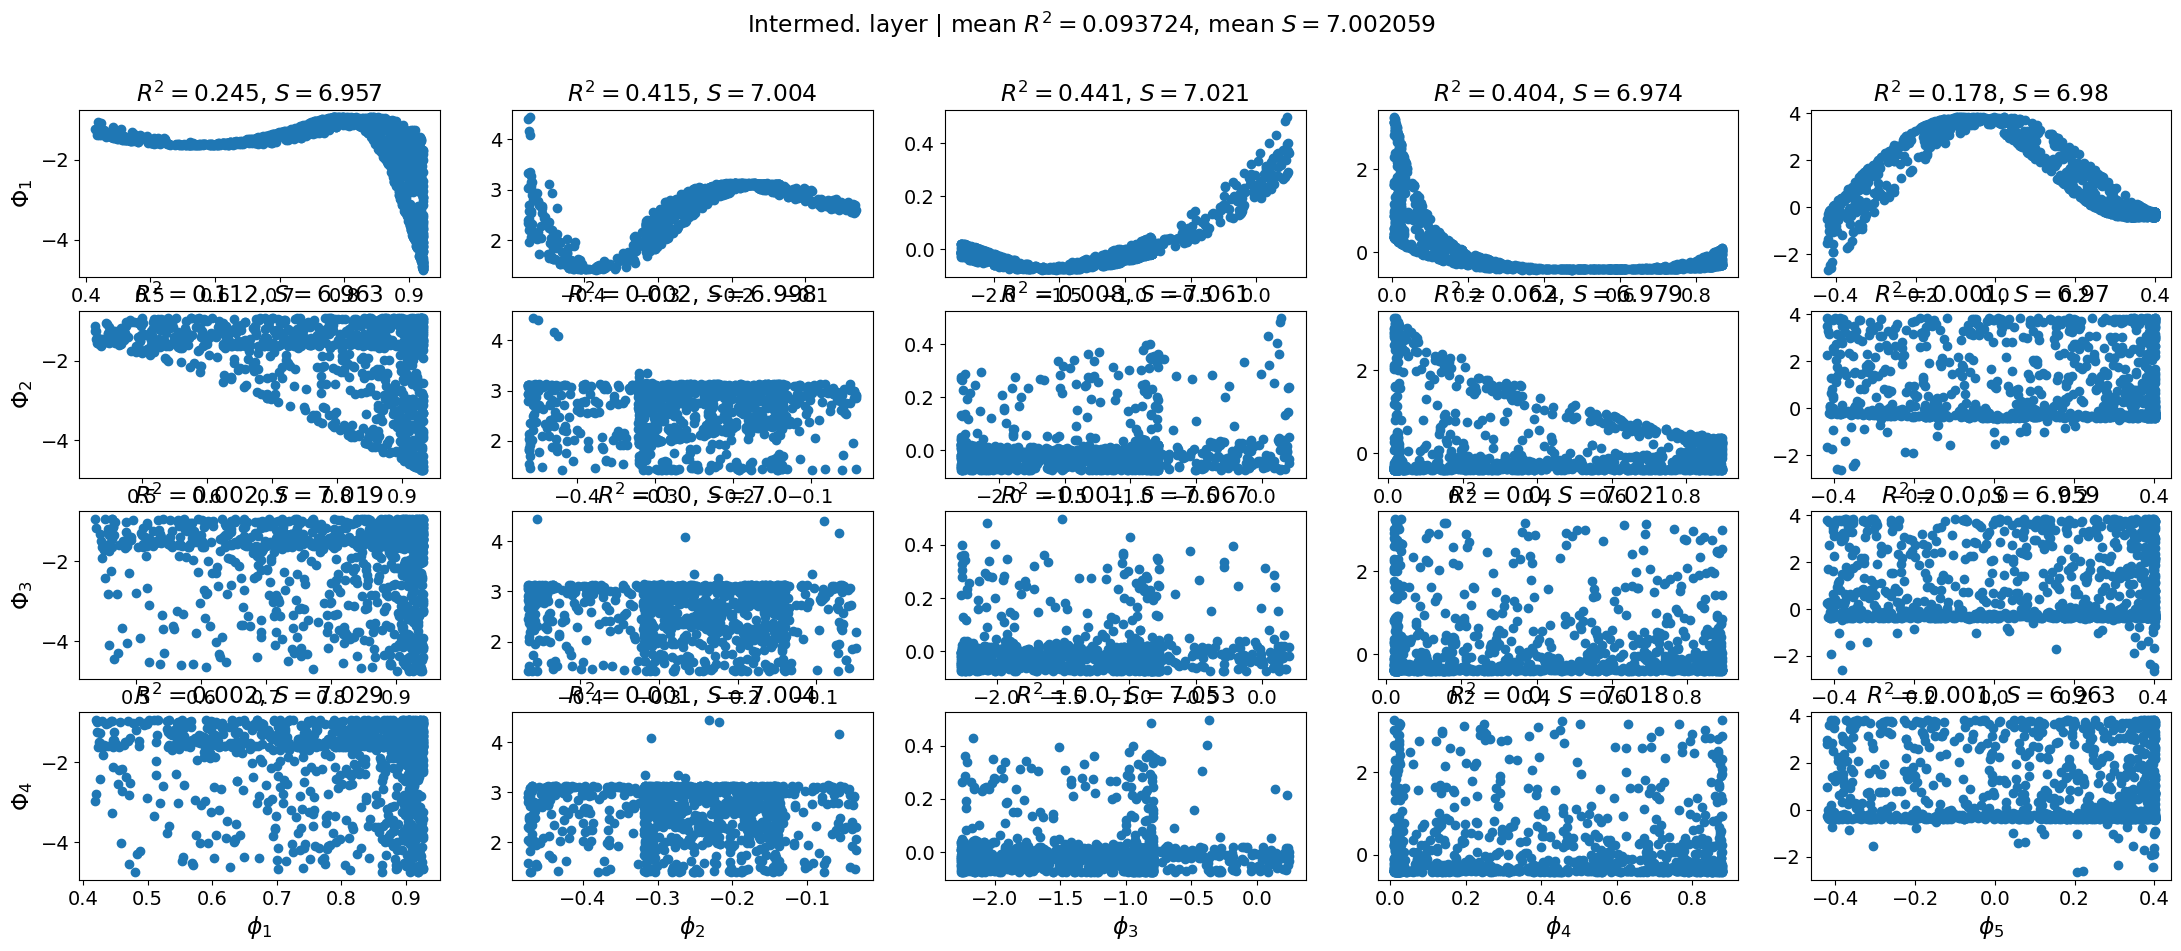

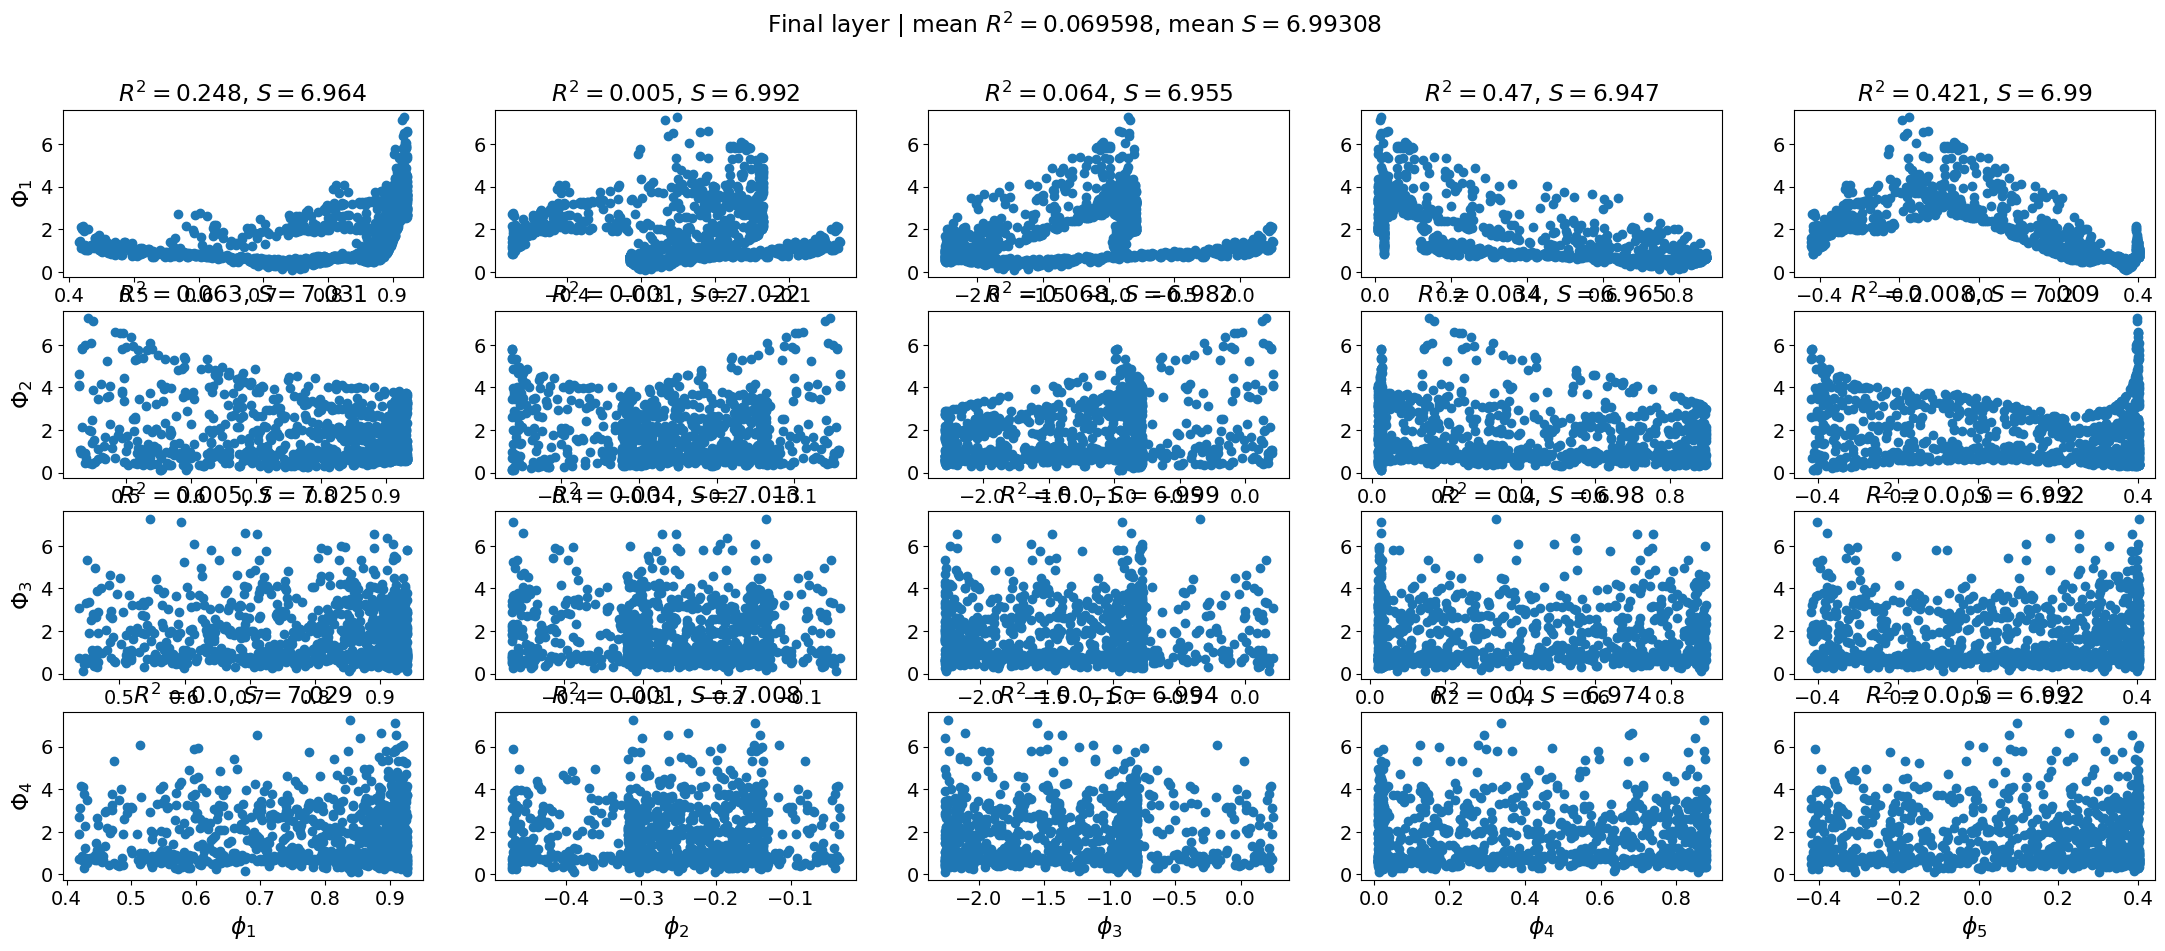

{'mean_r2': 0.06959810699449917, 'mean_matrix_entropy': 6.993080139160156}

In [26]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')


-----
-----
## $f_1(x_1, x_2, x_3, x_4)$

## $x_3, x_4$ - LC($x_3, x_4$) + normal random

##### $f_1(x_1, x_2, x_3, x_4) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$

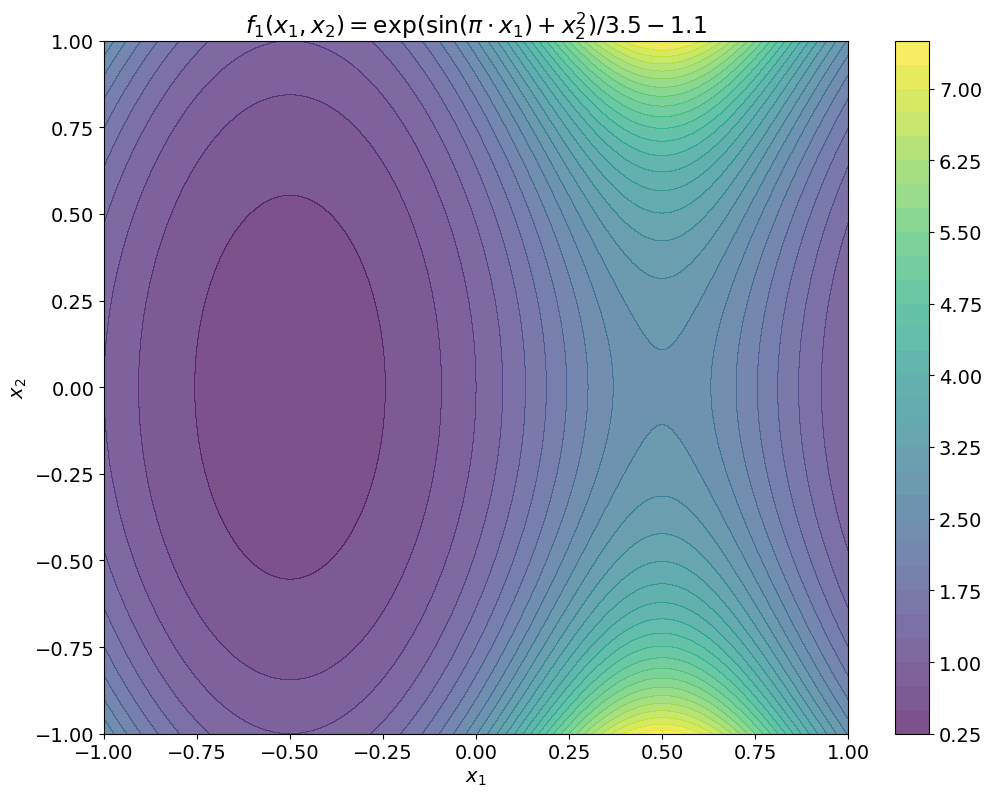

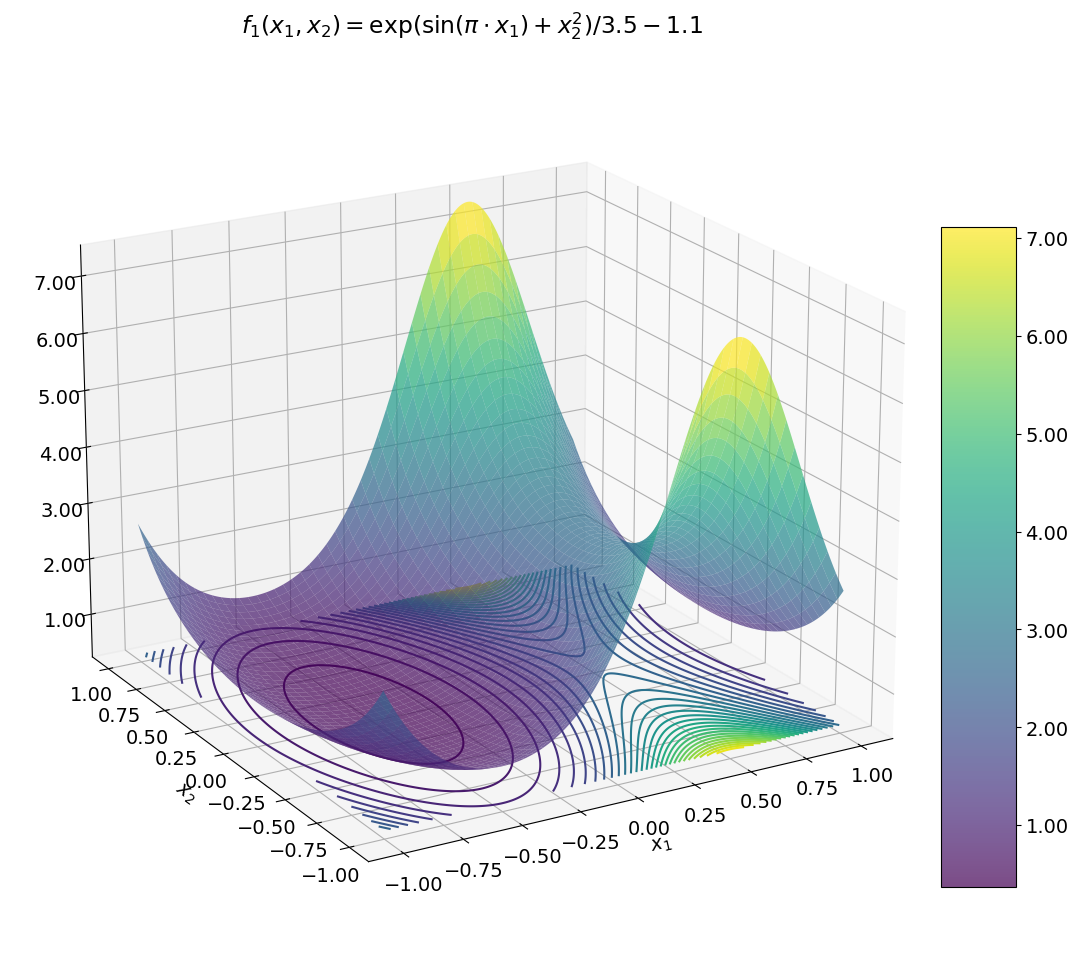

In [87]:
# create dataset
f1 = lambda x: torch.exp(torch.sin(torch.pi*x[:,[0]]) + x[:,[1]]**2)
dataset1 = create_dataset(f1, n_var=2, device=device)

# adding new inputs
SNR = 20 #noize_ampl=0.1 with SNR=20
noize_ampl = 10**(-SNR/20)

add_x = torch.stack((2**(-0.5)*dataset1['train_input'][:,0] + 2**(-0.5)*dataset1['train_input'][:,1] + noize_ampl*torch.randn(*dataset1['train_input'][:,0].shape),
                     2**(-0.5)*dataset1['train_input'][:,0] - 2**(-0.5)*dataset1['train_input'][:,1] + noize_ampl*torch.randn(*dataset1['train_input'][:,0].shape))
                     , dim=1)
dataset1['train_input'] = torch.concat((dataset1['train_input'], add_x), dim=1)

add_x = torch.stack((2**(-0.5)*dataset1['test_input'][:,0] + 2**(-0.5)*dataset1['test_input'][:,1] + noize_ampl*torch.randn(*dataset1['test_input'][:,0].shape),
                     2**(-0.5)*dataset1['test_input'][:,0] - 2**(-0.5)*dataset1['test_input'][:,1] + noize_ampl*torch.randn(*dataset1['test_input'][:,0].shape)), 
                    dim=1)
dataset1['test_input'] = torch.concat((dataset1['test_input'], add_x), dim=1)

f = f1
dataset = dataset1

plot_f_2d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')
plot_f_3d(f1, title='$f_1(x_1, x_2) = \exp(\sin(\pi \cdot x_1) +  x_2^2) / 3.5 - 1.1$')

-----
### MLP on $f_1$

№ model trainable params: 246


| train_loss: 1.87e-02 | test_loss: 1.85e-02 | reg: 1.19e+02 | : 100%|█| 100/100 [00:03<00:00, 25.80


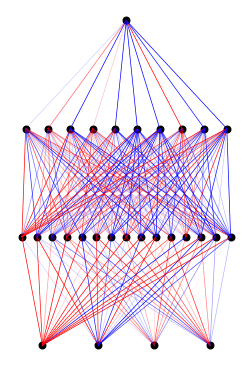

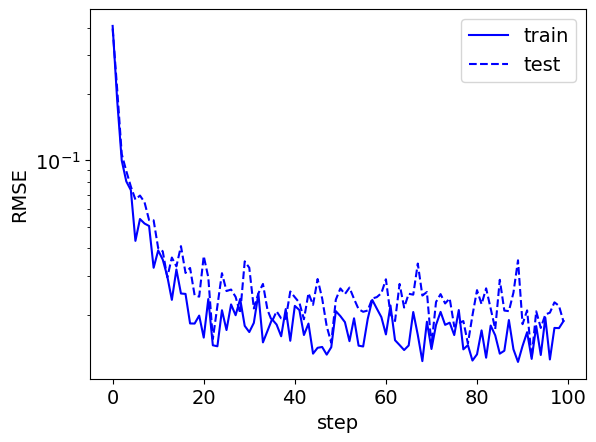

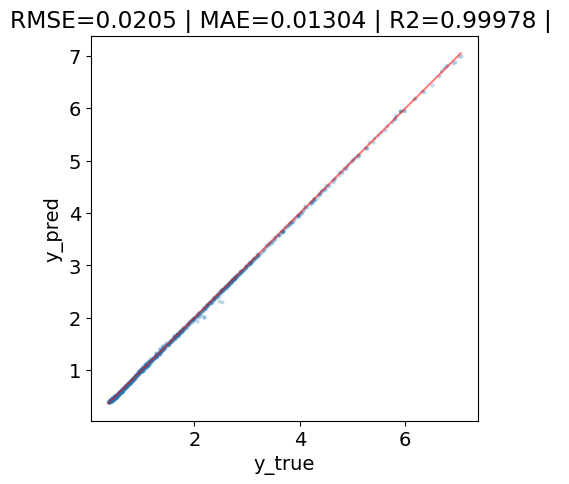

In [75]:
# initialize MLP
model = MLP(width=[4,15,10,1], seed=3, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb = 0, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 300


description:   0%|                                                          | 0/100 [00:00<?, ?it/s]

| train_loss: 6.80e-03 | test_loss: 6.96e-03 | reg: 8.22e+00 | : 100%|█| 100/100 [00:34<00:00,  2.91


saving model version 0.1


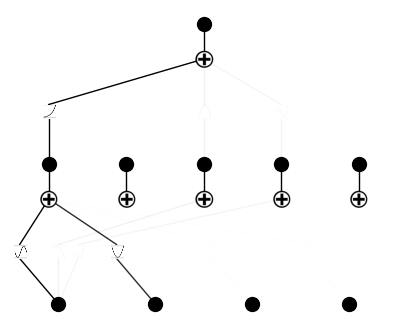

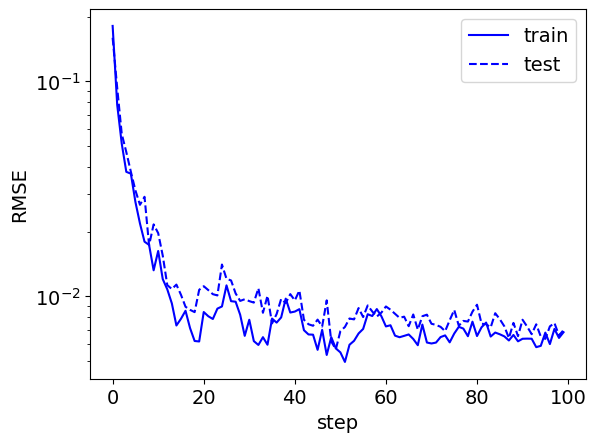

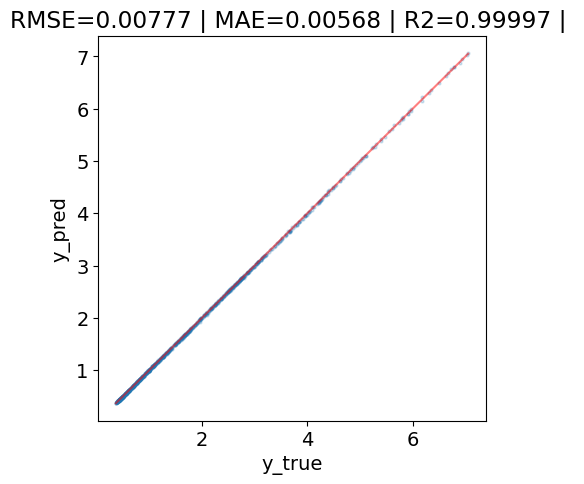

In [88]:
# initialize KAN with G=3
model = KAN(width=[4,5,1], grid=3, k=3, seed=2, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=100, lamb=1e-4, update_grid=False, batch=250)
kan_summary_after_fit(model, dataset, results)

-----
### $\lambda$-KAN on $f_1$

checkpoint directory created: ./model
saving model version 0.0
№ model trainable params: 184


description:   0%|                                                          | 0/150 [00:00<?, ?it/s]

| train_loss: 3.02e-01 | test_loss: 2.73e-01 | reg: 3.33e+01 | : 100%|█| 150/150 [00:41<00:00,  3.61


saving model version 0.1


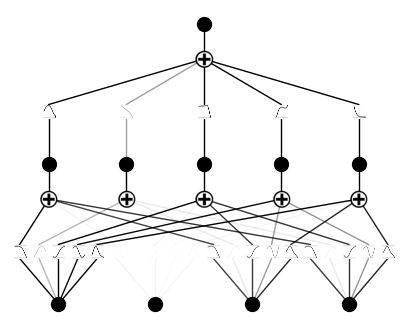

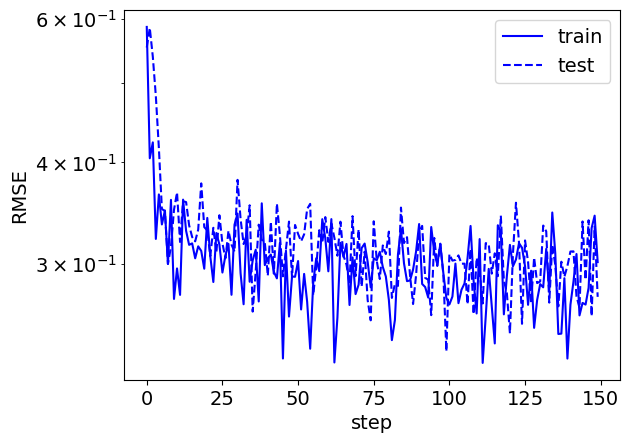

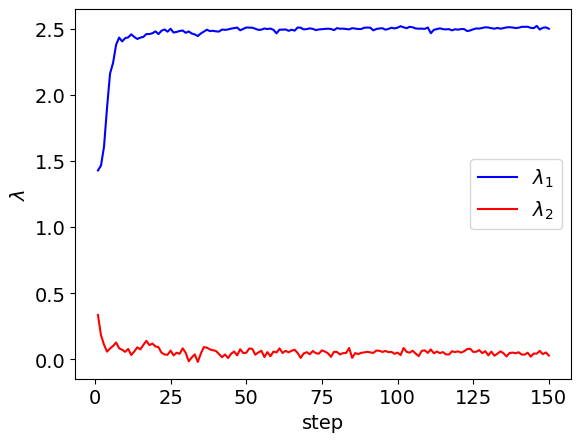

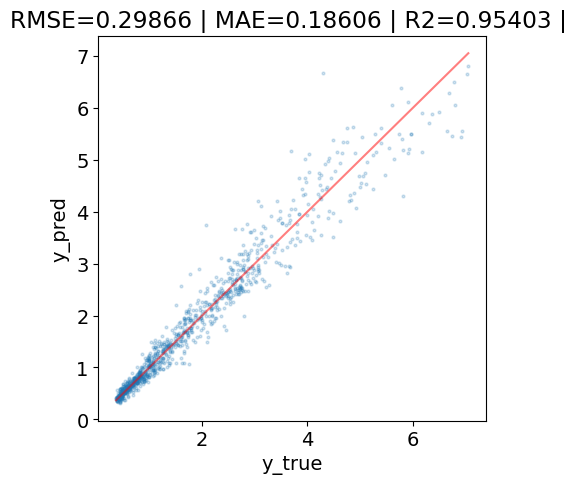

model.act_fun[0].lmd=Parameter containing:
tensor([2.4987, 0.0289, 0.7636, 0.7933], requires_grad=True)


In [90]:
# initialize lmdKAN with G=3
model = lmdKAN(width=[4,5,1], grid=3, k=3, seed=2, device=device)
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad) # trainable params

print(f'№ model trainable params: {pytorch_total_params}')

results = model.fit(dataset, steps=150, lamb = 1e-4, 
                    lamb_lmd_interm=0.0, lamb_lmd_final=0.0, reg_type='entropy',
                    batch=250)
kan_summary_after_fit(model, dataset, results, lmdKAN=True)
print(f'{model.act_fun[0].lmd=}')

ExactExplainer explainer: 1001it [00:29, 22.19it/s]                          


module of Input importance:


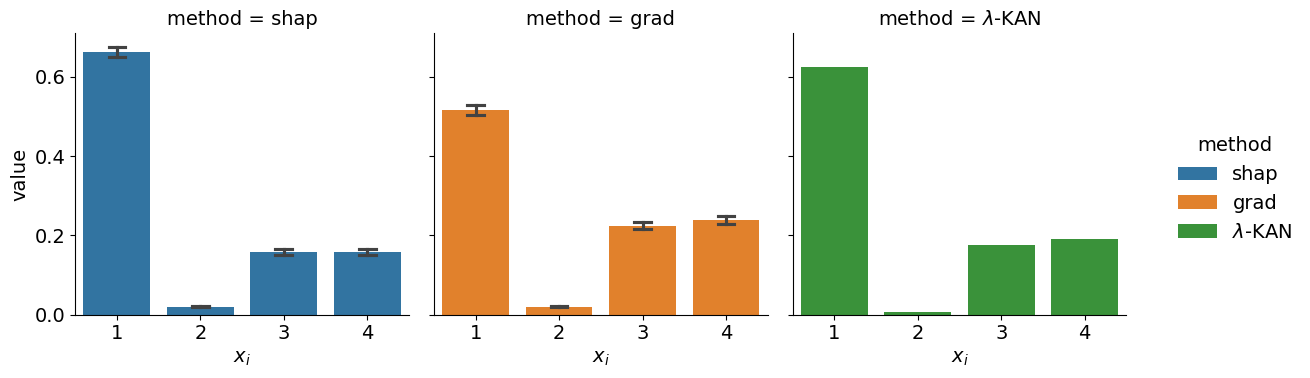

Input importance:


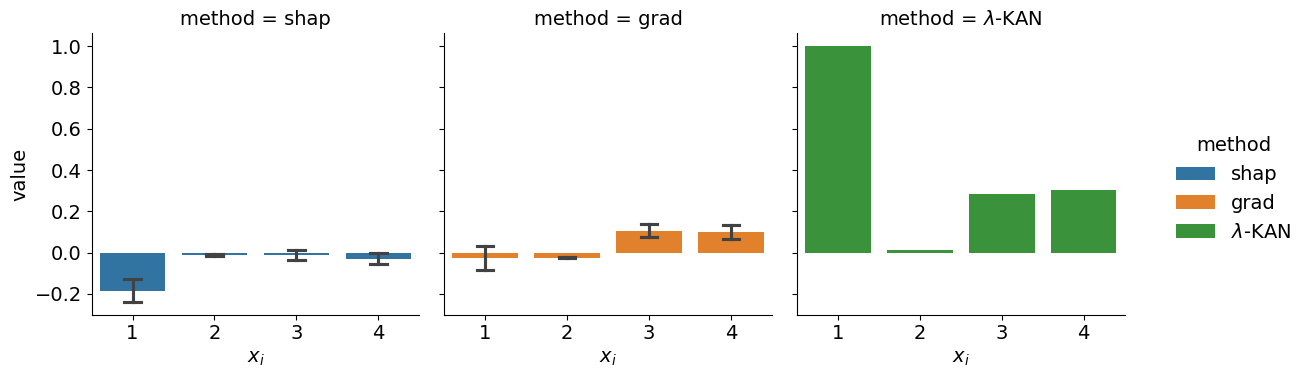

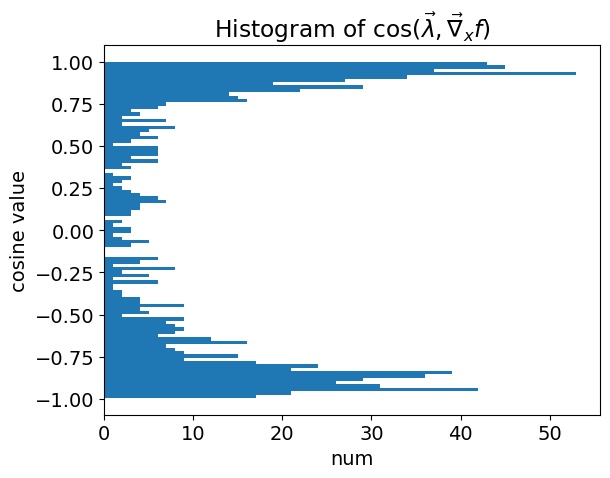

In [81]:
importance_analyse_lmdKAN(model, dataset)

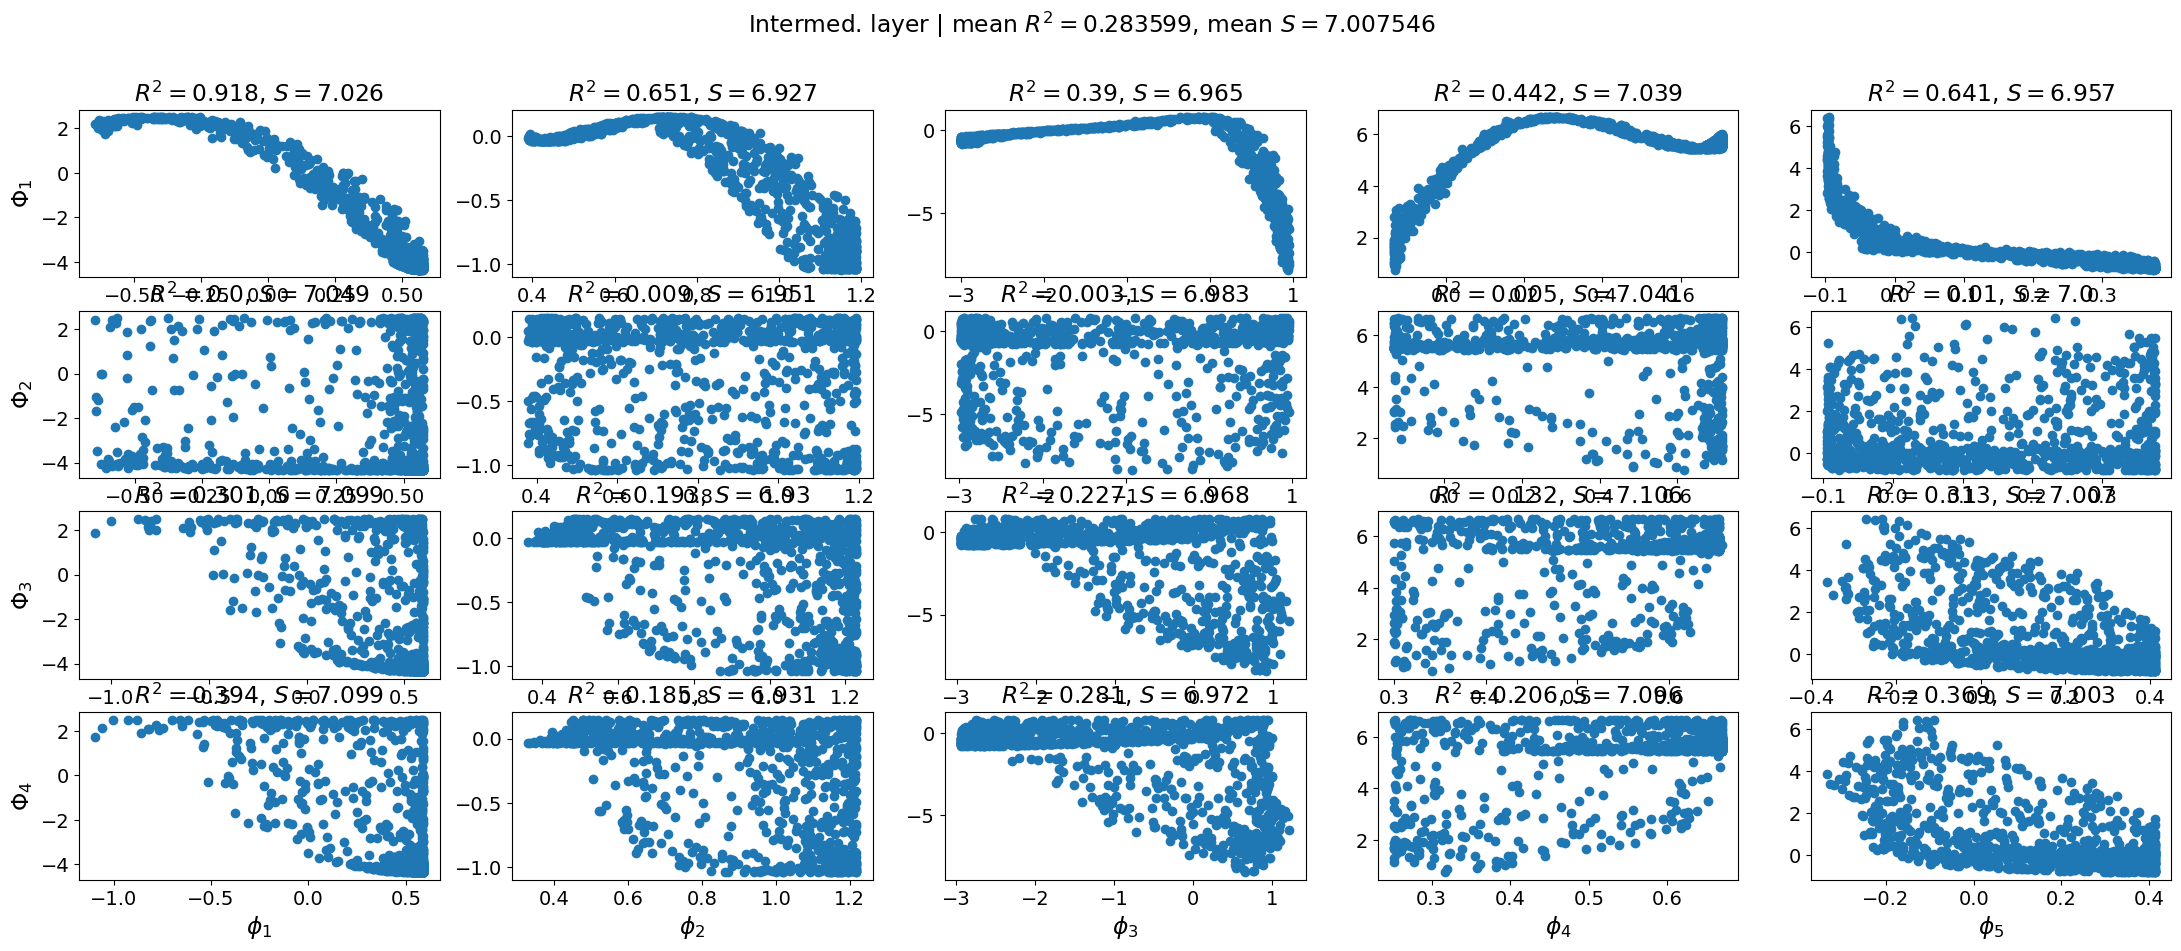

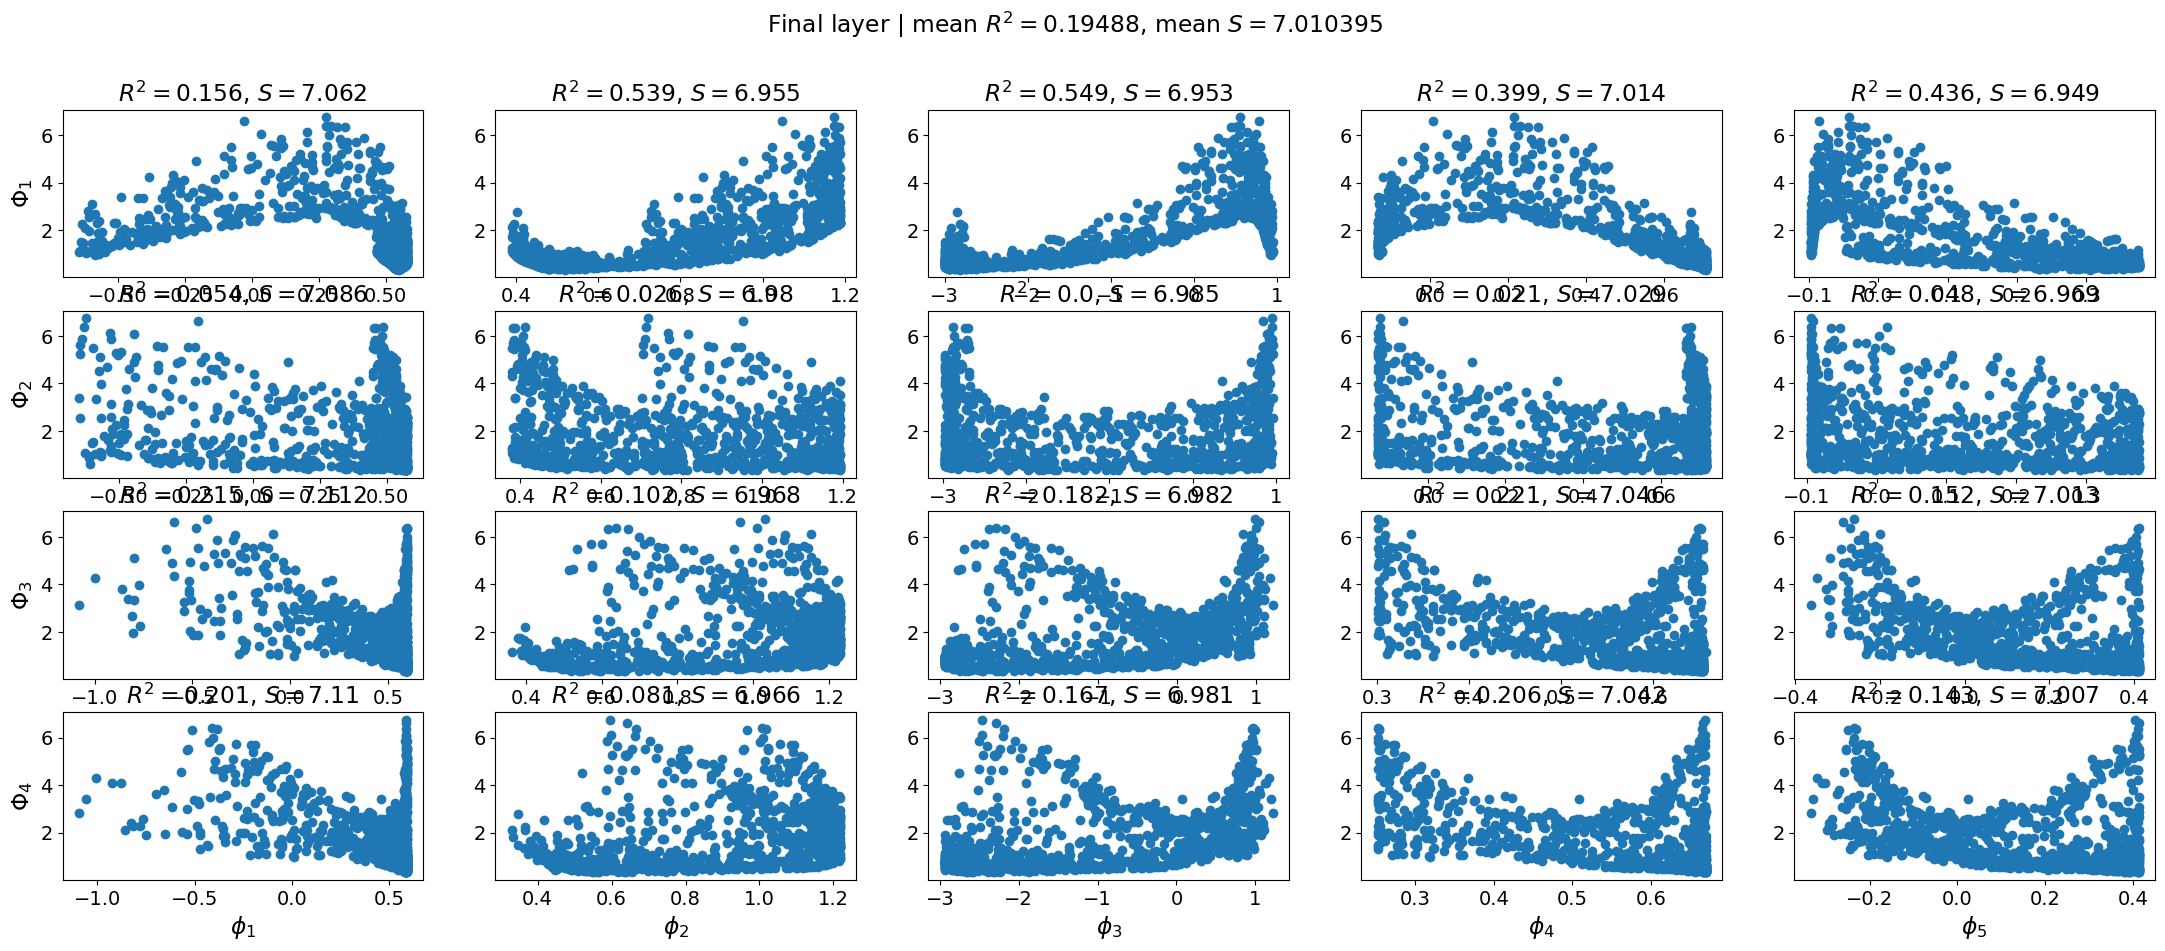

{'mean_r2': 0.19488041873992187, 'mean_matrix_entropy': 7.010395050048828}

In [79]:
model.lmd_corr_plot(title_text='Intermed. layer')
model.lmd_corr_plot(fin_layer=True, title_text='Final layer')